In [1]:
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from tqdm import tqdm
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
df = pd.read_csv('Pantaloon-MH-processed.csv')[['UID', 'Cleaned_Verbatim']][0:5000]

In [3]:
df['verbatim_word_count'] = df['Cleaned_Verbatim'].apply(lambda x: len(x.strip().split()))

In [4]:
df.head()

,UID,Cleaned_Verbatim,verbatim_word_count
0,36769324,1 . the fit & price was good . 2 . i was not l...,61
1,36769332,1 . i am satisfied with the staff service . 2 ...,39
2,36769602,1 . i am fine with the range and variety . 2 ....,59
3,36769609,1 . i like the the product quality 2 . i like ...,48
4,36769616,1 . staff service is good and i am satisfied ....,34


In [5]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['be',
 'into',
 'eleven',
 'everything',
 'afterwards',
 'whither',
 'hereafter',
 'off',
 'side',
 'seem']

In [6]:
# Parser
parser = spacy.load('en_core_web_sm')

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [7]:
tqdm.pandas()
df["processed_verbatim"] = df["Cleaned_Verbatim"].progress_apply(spacy_tokenizer)

/Users/ankur.kumar/tf2_env/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 5000/5000 [00:48<00:00, 103.33it/s]


In [8]:
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [9]:
text = df['processed_verbatim'].values
X = vectorize(text, 2 ** 10)
X.shape

(5000, 1024)

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(5000, 498)

In [11]:
from sklearn.cluster import KMeans
import numpy as np

In [12]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(10, 30)
for k in tqdm(K):
    k_means = KMeans(n_clusters=k, random_state=42, n_jobs=-1).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

100%|██████████| 20/20 [01:08<00:00,  3.42s/it]


In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

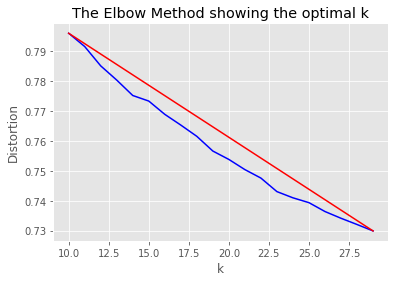

In [14]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [15]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=42, n_jobs=-1)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42, n_jobs=-1)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.445s...
[t-SNE] Computed neighbors for 5000 samples in 6.485s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.408687
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.451912
[t-SNE] KL divergence after 1000 iterations: 0.982026


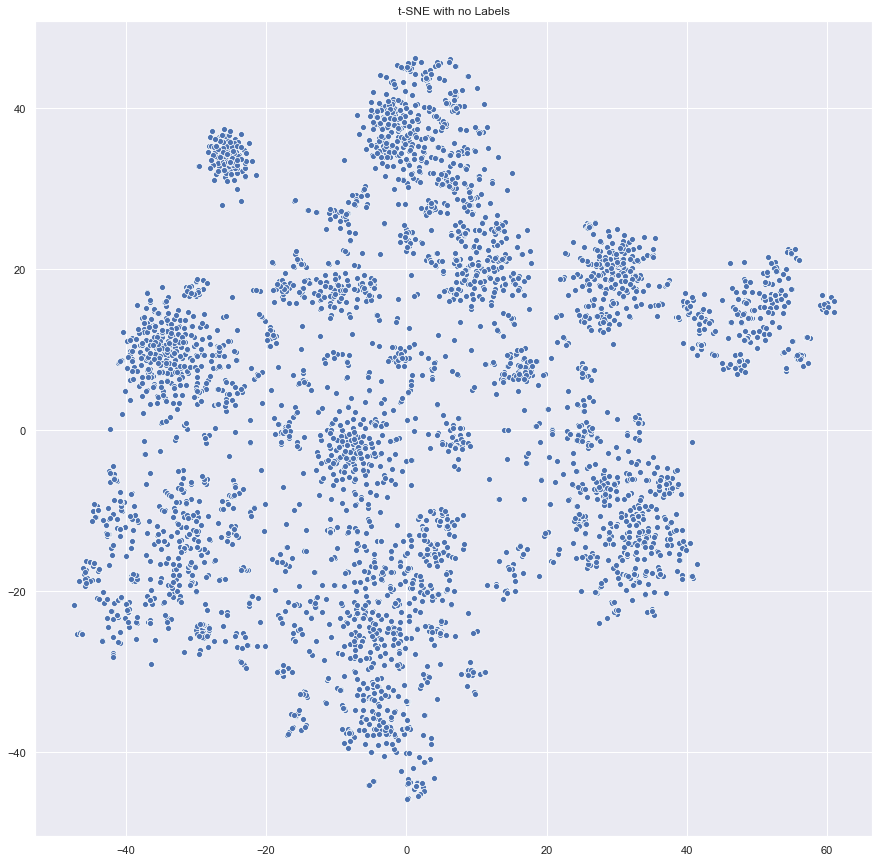

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()


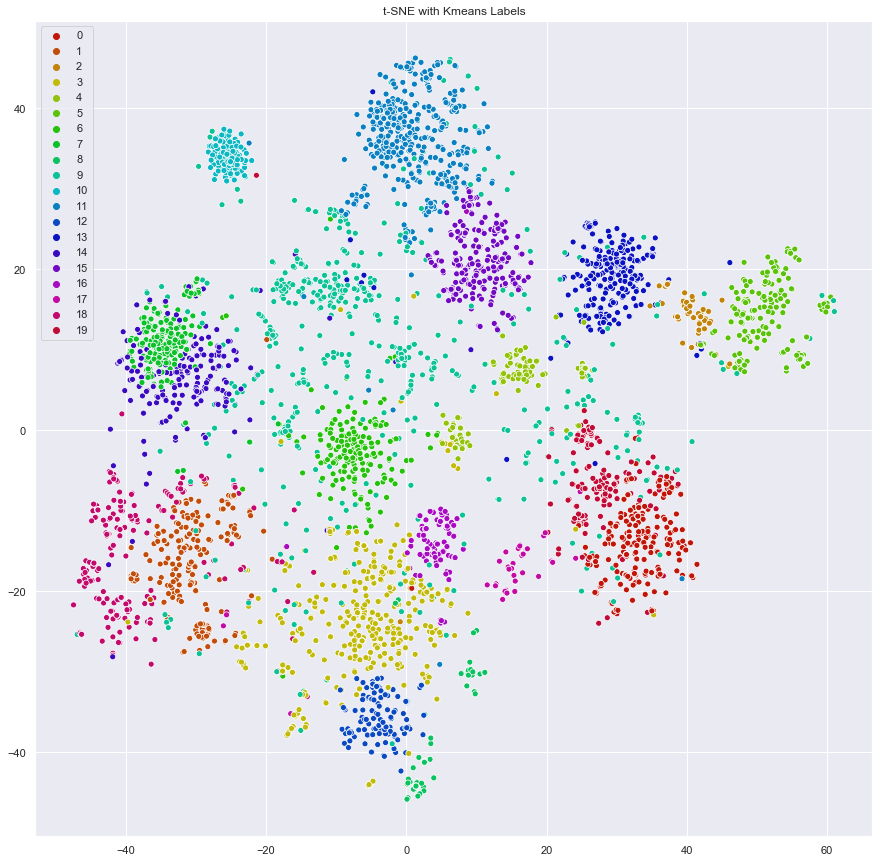

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15, 15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

In [19]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
vectorizers = []
    
for ii in range(0, 20):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [21]:
vectorizers[0]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=None, min_df=5,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}',
                tokenizer=None, vocabulary=None)

In [23]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_verbatim']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [24]:
len(vectorized_data)

20

In [25]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 20

lda_models = []
for ii in range(0, 20):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=False)

In [26]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

In [27]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [28]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [29]:
all_keywords[0][:10]

['mistake',
 'satisfied',
 'yesterday',
 'kid',
 'purchase',
 'store',
 'good',
 'pantaloon',
 'shirt',
 'like']

In [30]:
len(all_keywords)

20

In [31]:
f=open('topics.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

In [32]:
import pickle

# save the COVID-19 DataFrame, too large for github
pickle.dump(df, open("df_covid.p", "wb" ))

# save the final t-SNE
pickle.dump(X_embedded, open("X_embedded.p", "wb" ))

# save the labels generate with k-means(20)
pickle.dump(y_pred, open("y_pred.p", "wb" ))

In [33]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")

In [34]:
from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_pred, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 4000
X_test size: 1000 



In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=-1)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=-1)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  93.575 %
     Precision:  94.353 %
        Recall:  93.876 %
      F1 score:  94.080 %


In [36]:
# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3, n_jobs=-1)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_test, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  92.300 %
     Precision:  93.401 %
        Recall:  91.566 %
      F1 score:  92.333 %


In [37]:
sgd_cv_score = cross_val_score(sgd_clf, X.toarray(), y_pred, cv=10)
print("Mean cv Score - SGD: {:,.3f}".format(float(sgd_cv_score.mean()) * 100), "%")

Mean cv Score - SGD: 94.620 %


In [38]:
# required libraries for plot
from plot_text import header, description, description2, cite, description_search, description_slider, notes, dataset_description, toolbox_header 
from call_backs import input_callback, selected_code
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap, transform
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import RadioButtonGroup, TextInput, Div, Paragraph
from bokeh.layouts import column, widgetbox, row, layout
from bokeh.layouts import column

In [39]:
import importlib

In [40]:
import os

topic_path = os.path.join(os.getcwd(), '', 'topics.txt')
with open(topic_path) as f:
    topics = f.readlines()

In [41]:
df['title'] = 'title'
df['authors'] = 'authors'
df['journal'] = 'journal'
df['abstract_summary'] = 'abstract_summary'
df['doi'] = 'doi'

In [42]:
import random

In [47]:
# show on notebook
output_notebook()
# target labels
y_labels = y_pred

# data sources
source = ColumnDataSource(data=dict(
    x= X_embedded[:,0], 
    y= X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    desc= y_labels, 
    titles= df['title'],
    authors = df['authors'],
    journal = df['journal'],
    abstract = df['Cleaned_Verbatim'],
    labels = ["C-" + str(x) for x in y_labels],
    links = df['doi']
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Author(s)", "@authors{safe}"),
    ("Journal", "@journal"),
    ("Abstract", "@abstract{safe}"),
    ("Link", "@links")
],
point_policy="follow_mouse")

# map colors
initial_palette = Category20[20]
#random.Random(42).shuffle(initial_palette)

mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
plot = figure(plot_width=1200, plot_height=850, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save', 'tap'], 
           title="Clustering of the COVID-19 Literature with t-SNE and K-Means", 
           toolbar_location="above")

# plot settings
plot.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_width=1.1,
          line_color="black",
          legend = 'labels')
plot.legend.background_fill_alpha = 0.6

Loading BokehJS ...

In [48]:
# Keywords
text_banner = Paragraph(text= 'Keywords: Slide to specific cluster to see the keywords.', height=25)
input_callback_1 = input_callback(plot, source, text_banner, topics)

# currently selected article
div_curr = Div(text="""Click on a plot to see the link to the article.""",height=150)
callback_selected = CustomJS(args=dict(source=source, current_selection=div_curr), code=selected_code())
taptool = plot.select(type=TapTool)
taptool.callback = callback_selected

# WIDGETS
slider = Slider(start=0, end=20, value=20, step=1, title="Cluster #", callback=input_callback_1)
keyword = TextInput(title="Search:", callback=input_callback_1)

# pass call back arguments
input_callback_1.args["text"] = keyword
input_callback_1.args["slider"] = slider
# column(,,widgetbox(keyword),,widgetbox(slider),, notes, cite, cite2, cite3), plot

In [49]:
# STYLE
header.sizing_mode = "stretch_width"
header.style={'color': '#2e484c', 'font-family': 'Julius Sans One, sans-serif;'}
header.margin=5

description.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description.sizing_mode = "stretch_width"
description.margin = 5

description2.sizing_mode = "stretch_width"
description2.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description2.margin=10

description_slider.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description_slider.sizing_mode = "stretch_width"

description_search.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description_search.sizing_mode = "stretch_width"
description_search.margin = 5

slider.sizing_mode = "stretch_width"
slider.margin=15

keyword.sizing_mode = "scale_both"
keyword.margin=15

div_curr.style={'color': '#BF0A30', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
div_curr.sizing_mode = "scale_both"
div_curr.margin = 20

text_banner.style={'color': '#0269A4', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
text_banner.sizing_mode = "scale_both"
text_banner.margin = 20

plot.sizing_mode = "scale_both"
plot.margin = 5

dataset_description.sizing_mode = "stretch_width"
dataset_description.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
dataset_description.margin=10

notes.sizing_mode = "stretch_width"
notes.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
notes.margin=10

cite.sizing_mode = "stretch_width"
cite.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
cite.margin=10

r = row(div_curr,text_banner)
r.sizing_mode = "stretch_width"

In [50]:
# LAYOUT OF THE PAGE
l = layout([
    [header],
    [description],
    [description_slider, description_search],
    [slider, keyword],
    [text_banner],
    [div_curr],
    [plot],
    [description2, dataset_description, notes, cite],
])
l.sizing_mode = "scale_both"


# show
output_file('t-sne_covid-19_interactive.html')
show(l)